# Estimation of MODIS-like Surface-Spectral Reflectance from Geostationary Satellites using Deep Neural Networks 

## Setup

In [1]:
%matplotlib inline
# MCD43B3, MOD09A1
import argparse
import datetime
import glob
import os

import gdal
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt

In [2]:
originX = 85  # starting longitude
originY = -60  # starting latitude
pixelWidth = 0.01
pixelHeight = 0.01
mem_driver = gdal.GetDriverByName('MEM') # for in-memory warping
raw_dir = "modis"

In [3]:
layers = ["250m 16 days composite day of the year", # doy 1st for compositing reasons
          "250m 16 days NDVI", 
          "250m 16 days NIR reflectance"] 
raw_files = glob.glob(raw_dir + '/*.hdf')
raw_files[:5]

['modis/MOD13Q1.A2016225.h23v11.005.2016243094838.hdf',
 'modis/MOD13Q1.A2016225.h31v06.005.2016243093313.hdf',
 'modis/MOD13Q1.A2016225.h32v09.005.2016243095547.hdf',
 'modis/MOD13Q1.A2016225.h26v03.005.2016243101730.hdf',
 'modis/MOD13Q1.A2016225.h25v05.005.2016243103211.hdf']

In [4]:
filepath = raw_files[3] # set day here
day_of_year = 225 # int(filepath.split('.')[4][4:7])
filepath, day_of_year

('modis/MOD13Q1.A2016225.h26v03.005.2016243101730.hdf', 225)

In [5]:
ds = gdal.Open(filepath, gdal.GA_ReadOnly)
datasets = ds.GetSubDatasets()
datasets[:2]

[('HDF4_EOS:EOS_GRID:"modis/MOD13Q1.A2016225.h26v03.005.2016243101730.hdf":MODIS_Grid_16DAY_250m_500m_VI:250m 16 days NDVI',
  '[4800x4800] 250m 16 days NDVI MODIS_Grid_16DAY_250m_500m_VI (16-bit integer)'),
 ('HDF4_EOS:EOS_GRID:"modis/MOD13Q1.A2016225.h26v03.005.2016243101730.hdf":MODIS_Grid_16DAY_250m_500m_VI:250m 16 days EVI',
  '[4800x4800] 250m 16 days EVI MODIS_Grid_16DAY_250m_500m_VI (16-bit integer)')]

## Day of Year

In [6]:
doy_layer = ""
for dataset in datasets:
    if layers[0] in dataset[0]:
        doy_layer = dataset[0]
file_type = doy_layer.split(' ')[3].lower()
doy_layer, file_type

('HDF4_EOS:EOS_GRID:"modis/MOD13Q1.A2016225.h26v03.005.2016243101730.hdf":MODIS_Grid_16DAY_250m_500m_VI:250m 16 days composite day of the year',
 'composite')

In [7]:
doy_modis = gdal.Open(doy_layer)
doy_modis.ReadAsArray()

array([[ -1,  -1,  -1, ...,  -1,  -1,  -1],
       [ -1,  -1,  -1, ...,  -1,  -1,  -1],
       [ -1,  -1,  -1, ...,  -1,  -1,  -1],
       ..., 
       [240, 229, 240, ..., 233, 233, 233],
       [240, 240, 240, ..., 233, 233, 233],
       [230, 240, 240, ..., 233, 233, 233]], dtype=int16)

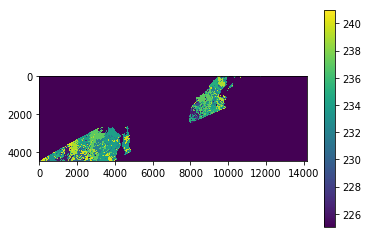

In [8]:
output = filepath.replace('.hdf', file_type + "-test.tif")
gdal.Warp(output, doy_modis, dstSRS='EPSG:3857')
data = gdal.Open(output)
doy_arr = data.ReadAsArray()
plt.imshow(doy_arr)
plt.clim(day_of_year, day_of_year + 16)
plt.colorbar()

## Near Infrared

In [9]:
nir_layer = ""
for dataset in datasets:
    if layers[2] in dataset[0]:
        nir_layer = dataset[0]
        
file_type = nir_layer.split(' ')[3].lower()
nir_layer, file_type

('HDF4_EOS:EOS_GRID:"modis/MOD13Q1.A2016225.h26v03.005.2016243101730.hdf":MODIS_Grid_16DAY_250m_500m_VI:250m 16 days NIR reflectance',
 'nir')

In [10]:
nir_modis = gdal.Open(nir_layer)
nir_modis.ReadAsArray()

array([[-1000, -1000, -1000, ..., -1000, -1000, -1000],
       [-1000, -1000, -1000, ..., -1000, -1000, -1000],
       [-1000, -1000, -1000, ..., -1000, -1000, -1000],
       ..., 
       [ 3105,  3182,  2881, ...,  5085,  4777,  4777],
       [ 2767,  2835,  2888, ...,  4129,  4129,  4240],
       [ 3903,  2974,  2825, ...,  3508,  3508,  3750]], dtype=int16)

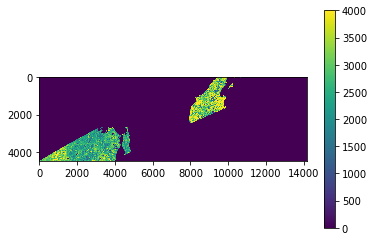

In [11]:
output = filepath.replace('.hdf', file_type + "-test.tif")
gdal.Warp(output, nir_modis, dstSRS='EPSG:3857')
data = gdal.Open(output)
nir_arr = data.ReadAsArray()
plt.imshow(nir_arr)
plt.clim(0,4000)
plt.colorbar()

In [13]:
doy = int(filepath.split('.')[1][5:])
year = int(filepath.split('.')[4][0:4])
date = datetime.datetime(year, 1, 1) + datetime.timedelta(doy - 1)

# Find closest himawari times
modis_time = filepath.split('.')[4][7:]
_time = datetime.datetime.strptime(modis_time, "%H%M%S")
if _time.minute % 10 >= 5:
    _time += datetime.timedelta(minutes=10 - _time.minute % 10)
else:
    _time += datetime.timedelta(minutes=-_time.minute % 10)
timendate = datetime.datetime.combine(date.date(), _time.time())
timendate.strftime('%Y-%m-%d %H:%M')

'2016-08-12 10:20'

In [14]:
himawari_raw_files = [(timendate + datetime.timedelta(days=i)).strftime("%Y%m%d%H%M.*.dat".format(file_type)) 
                           for i in range(16)] # raw files
himawari_files = ['processed/' + (timendate + datetime.timedelta(days=i)).strftime("%Y%m%d%H%M.{}.tif".format(file_type))
                            for i in range(16)] # processed files
himawari_raw_files[:3], [os.path.isfile(f) for f in himawari_raw_files]


(['201608121020.*.dat', '201608131020.*.dat', '201608141020.*.dat'],
 [False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False])

In [16]:
file_exists = [os.path.isfile(f) for f in himawari_raw_files]
for exists, h in zip(file_exists, himawari_raw_files):
    if not exists:
        os.system('aws s3 sync s3://himawari-nex/radiance/ data/himawari/ --exclude "*" --include "{}"'.format(h))
        print h

201608121020.*.dat
201608131020.*.dat
201608141020.*.dat
201608151020.*.dat
201608161020.*.dat
201608171020.*.dat
201608181020.*.dat
201608191020.*.dat
201608201020.*.dat
201608211020.*.dat
201608221020.*.dat
201608231020.*.dat
201608241020.*.dat
201608251020.*.dat
201608261020.*.dat
201608271020.*.dat


In [24]:
file_exists = [os.path.isfile('himawari/' + f.replace('*', 'ext.01.fld.geoss')) for f in himawari_raw_files]
all(file_exists)

True

In [27]:
import scipy.ndimage

In [33]:
# resize image using nearest neighbor (order 0)
resized_nir = scipy.ndimage.zoom(nir_arr, 0.125, order=0)
resized_nir.shape, nir_arr.shape

((560, 1772), (4479, 14176))

In [38]:
ulx, xres, xskew, uly, yskew, yres = data.GetGeoTransform()
lrx = ulx + (data.RasterXSize * xres)
lry = uly + (data.RasterYSize * yres)
modis_shape = resized_nir.shape
matrix = np.zeros((modis_shape[0], modis_shape[1], 16))  # create the array

In [ ]:
for i, f in enumerate(himawari_files):
    himawari_unwarped = gdal.Open(f, gdal.GA_ReadOnly)
    # Do the needful
    himawari_warped = 'hw.tif'
    gdal.Warp(himawari_warped, himawari_unwarped, srcSRS='EPSG:4326', dstSRS='EPSG:3857')
    himawari_cutout = output + '-test-2.tif'
    gdal.Warp(himawari_cutout, himawari_warped, outputBoundsSRS='EPSG:3857', outputBounds=[ulx, lry, lrx, uly])
    print "Opening layer", i
    data = gdal.Open(himawari_cutout, gdal.GA_ReadOnly)
    d = data.GetRasterBand(1).ReadAsArray()
    print "Done"
    print modis_shape, d.shape
    data = d[:modis_shape[0], :modis_shape[1]]
    print "D.shape", data.shape
    print "Data not null", data[data > 0]
    matrix[:, :, i] = data